In [1]:
# Im adding the heart rate into the features extracted using a heuristic function based on these rules 

# Pitch (F0) — higher pitch means higher heart rate
# Energy — louder speech means higher heart rate
# Speaking rate — faster speech means higher heart rate

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("speech_features.csv")

In [8]:
pitch_max = np.percentile(df['pitch_mean'], 95)
energy_max = np.percentile(df['energy'], 95)
rate_max = np.percentile(df['speaking_rate'], 95)

print(f"pitch_max ~ {pitch_max:.1f}, energy_max ~ {energy_max:.1f}, rate_max ~ {rate_max:.1f}")

pitch_max ~ 1912.8, energy_max ~ 30.1, rate_max ~ 10.9


In [12]:
def simulate_heart_rate(row, pitch_max=1912.8, energy_max=30.1, rate_max=10.9):
    resting_hr = 60  # more typical resting baseline
    
    # Normalize
    pitch_norm = np.clip(row['pitch_mean'] / pitch_max, 0, 1)
    energy_norm = np.clip(row['energy'] / energy_max, 0, 1)
    rate_norm = np.clip(row['speaking_rate'] / rate_max, 0, 1)
    
    # Smaller effects with gentler curves
    pitch_effect = 6 * np.tanh(2 * pitch_norm)         # max ~6 bpm
    energy_effect = 5 * (energy_norm ** 1.3)           # max ~5 bpm
    rate_effect = 7 * np.sqrt(rate_norm)                # max ~7 bpm
    interaction = 4 * pitch_norm * rate_norm            # combined effect max ~4 bpm

    hr = resting_hr + pitch_effect + energy_effect + rate_effect + interaction

    # Slightly higher noise for natural spread
    noise = np.random.normal(0, 5)
    hr += noise

    hr = np.clip(hr, 50, 110)  # clip to more plausible range for calm speech
    
    return hr


In [13]:
df["simulated_hr"] = df.apply(simulate_heart_rate, axis=1)

df.to_csv("speech_features_with_hr.csv", index=False)

print("done.")

done.


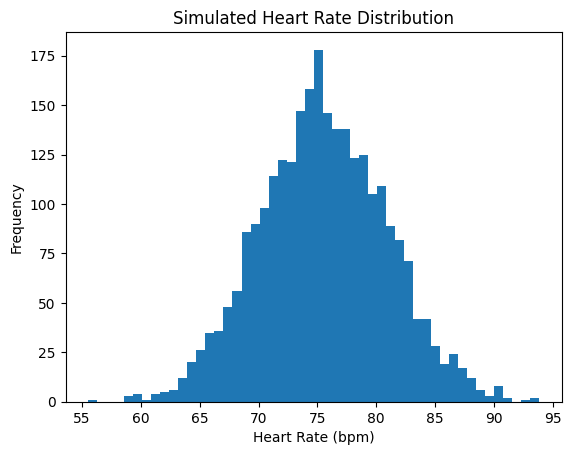

In [14]:
import matplotlib.pyplot as plt

plt.hist(df['simulated_hr'], bins=50)
plt.title("Simulated Heart Rate Distribution")
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Frequency")
plt.show()
